# Atividade 8

Nesta atividade iremos realizar alguns testes com o classificador Redes Neurais (Multilayer Perceptron) na nossa base de dados, adaptando-o de acordo com as características da nossa base.

## 0. Preparação do ambiente.
Para os trabalhos desta atividade utilizaremos a base de dados previamente carregada no Github, [neste link](https://github.com/danielbdias/pattern-recognition-studies.git), em conjunto com alguns scripts auxiliares

In [2]:
# prepara a máquina local do google colab para receber a base (quando necessário)
# e baixa os scripts auxiliares para a montagem do notebook
!rm -rf ./*

!git clone https://github.com/danielbdias/pattern-recognition-studies.git
!mv ./pattern-recognition-studies/* ./
!rm -rf ./pattern-recognition-studies
!rm -rf ./sample_data

!pip install -r requirements.txt

Cloning into 'pattern-recognition-studies'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 100 (delta 34), reused 93 (delta 27), pack-reused 0
Receiving objects: 100% (100/100), 22.34 MiB | 7.78 MiB/s, done.
Resolving deltas: 100% (34/34), done.
     |████████████████████████████████| 7.6MB 12.1MB/s 
     |████████████████████████████████| 163kB 50.0MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
  Created wheel for sklearn-genetic: filename=sklearn_genetic-0.2-py2.py3-none-any.whl size=6695 sha256=affbdfc1e1811387c6748d22f035509fa2b21354cfaedce772d1276b7f288096
  Stored in directory: /root/.cache/pip/wheels/e0/0d/a7/698bc5a79bdf76ad619116359c01dcc40298b8b275279fd826
  Created wheel for skrebate: filename=skrebate-0.6-cp36-none-any.whl size=29329 sha256=885633c8c6ee945c0ffbb7d3ba1d485747899afcfb8114f488830e132d14beba
  Stored in directory: /root/.cache/pip/wheels/f5/99/

In [3]:
# imports de libs necessárias para as análises
from scripts.database import load_datapoints_with_targets
from scripts.preprocessing import centralize_observations, principal_component_analysis
from scripts.classification import run_classifier_with_stratified_k_fold
from scripts.graphics import plot_metric

import numpy as np
import pandas as pd
import scipy.stats as st

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

## 1. Base de dados

Para o nosso trabalho, estamos utilizando o dataset [Grammatical Facial Expressions](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions), que descreve expressões faciais gramaticais da linguagem brasileira de sinais (Libras).

A base possui `27965 instâncias`, subdivididas em 9 expressões: `Interrogativa (qu)`,`Interrogativa (s/n)`, `Interrogativa (dúvida)`, `Negativa`, `Afirmativa`, `Condicional`, `Relativa`, `Tópico` e `Foco`. 

Cada instância é estruturada em `300 características`, que representam 100 pontos com coordenadas (x, y, z) da face, seguindo a ordem abaixo:

| Coordenadas (x,y,z) | Região da Face | Coordenadas (x,y,z) | Região da Face |
| --- | --- | --- | --- |
| 0 - 7 (x,y,z) | olho esquerdo | 68 - 86 (x,y,z) | contorno da face |
| 8 - 15 (x,y,z) | olho direito | 87 (x,y,z) | iris esquerda |
| 16 - 25 (x,y,z) | sobrancelha esquerda | 88 (x,y,z) | iris direita |
| 26 - 35 (x,y,z) | sobrancelha direita | 89 (x,y,z) | ponta do nariz |
| 36 - 47 (x,y,z) | nariz | 90 - 94 (x,y,z) | linha acima da sobrancelha esquerda |
| 48 - 67 (x,y,z) | boca | 95 - 99 (x,y,z) | linha acima da sobrancelha direita |

Não há missing values nesses pontos e eles não por um processo de normalização. A classificação de instância é binária onde ela pode ser "Com Expressão" (`"Expression"`, onde os pontos representam a expressão facial) ou "Sem Expressão" (`"Not Expression"`, os pontos não representam uma expressão).

Normalizamos a base buscando centralizar cada frame (observação) em relação a um ponto em comum no frame.
Escolhemos o ponto 89 (`nose tip`) como referência e aplicamos o processo nas seguintes etapas:

1.   Encontramos os valores médios para o ponto 89 nos valores de `x` e `y` (ignoramos o valor de `z` por ele usar uma medida em milimetros ao invés de em pixels, [referência](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions#));
2.   Calculamos os deltas do ponto 89 de cada observação em relação aos valores médios encontrados;
3.   Subtraimos esse delta de todos os pontos de cada observação.

Nesta atividade utilizaremos somente as observações da expressão facial `negativa` em sua forma pré-processada (com os pontos centralizados) de quatro formas diferentes:

- Base com todas as características
- Base transformada pela técnica PCA (resultante da Atividade 03)
- Base com as características encontradas pelo Relief-F (resultante da Atividade 04)
- Base com as características encontradas pelo Algoritmo Genético (resultante da Atividade 04)

### 1.1 Base total (todas as características)

A base de dados com todas as características contém 300 dimensões, estruturadas da seguinte forma:

In [4]:
category = 'negative'
raw_data = load_datapoints_with_targets(category)

dataset = centralize_observations(raw_data)
dataset.describe()

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,3y,3z,4x,4y,4z,5x,5y,5z,6x,6y,6z,7x,7y,7z,8x,8y,8z,9x,9y,9z,10x,10y,10z,11x,11y,11z,12x,12y,12z,13x,...,87x,87y,87z,88x,88y,88z,89x,89y,89z,90x,90y,90z,91x,91y,91z,92x,92y,92z,93x,93y,93z,94x,94y,94z,95x,95y,95z,96x,96y,96z,97x,97y,97z,98x,98y,98z,99x,99y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2.706000e+03,2.706000e+03,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,309.397827,219.230181,1060.284922,306.747875,217.450552,1131.164819,303.378426,216.894622,1193.764597,300.074385,217.609761,1223.556911,297.665360,219.436908,1230.535107,300.274563,220.322486,1176.263489,303.444313,220.526974,1038.365484,306.640969,220.100104,1009.759793,326.157344,218.936293,1217.437177,328.736993,217.149242,1256.204361,332.182324,216.502080,1259.902809,335.554792,217.133067,1264.280488,338.082337,218.819187,1268.604213,335.520073,...,303.452959,218.946443,1129.608278,332.199567,218.505385,1258.258315,3.176599e+02,2.318791e+02,1209.664080,310.826266,207.354693,1233.516999,305.369000,206.004435,1251.558389,298.691503,205.918653,1270.532151,293.515367,208.221425,1274.541020,290.435373,211.310969,1275.635625,323.691057,206.891941,1226.466741,329.254277,205.524790,1264.941981,336.213900,205.329225,1272.370658,341.628362,207.474289,1184.382114,344.936643,210.218903,986.881744,0.458241
std,1.625597,2.741896,439.370887,1.766325,2.647455,361.558210,1.909747,2.545192,266.930040,2.068360,2.604414,207.681415,2.276244,2.819885,189.524172,2.035129,2.627748,305.195326,1.837146,2.588349,467.862472,1.709180,2.618346,486.391245,1.293026,3.476340,213.039276,1.410117,3.671390,44.426491,1.565801,3.850135,28.496103,1.709296,4.207239,27.997756,1.694350,4.656406,27.170327,1.536700,...,1.882926,2.636571,371.228189,1.457187,3.943149,27.988910,1.967146e-11,7.334156e-12,185.659502,2.173587,3.047111,100.384009,2.217401,3.209743,82.158638,2.736837,3.614539,42.217173,3.124719,4.163845,36.093727,3.307145,4.599675,37.270430,2.336497,3.729178,214.587202,3.018665,4.355729,85.920339,3.905090,5.389459,89.417381,3.914957,6.521451,351.531081,3.385256,7.330508,555.178027,0.498345
min,303.950854,209.797120,0.000000,300.704854,207.540120,0.000000,296.182854,206.904120,0.000000,291.035854,207.485120,0.000000,287.269854,209.065120,0.000000,291.205854,211.018120,0.000000,296.321854,211.669120,0.000000,300.562854,211.224120,0.000000,320.645854,208.774120,0.000000,322.707854,206.091120,0.000000,325.613854,204.980120,861.000000,328.421854,205.173120,872.000000,330.579854,206.507120,877.000000,328.820854,...,296.225854,209.338120,0.000000,325.812854,207.452120,861.000000,3.176599e+02,2.318791e+02,0.000000,303.893854,195.724120,0.000000,298.229854,193.849120,0.000000,287.040854,193.485120,0.000000,278.779854,193.987120,859.000000,274.172854,196.015120,861.000000,316.851854,195.678120,0.000000,320.206854,193.750120,0.000000,324.399854,191.588120,0.000000,329.433854,190.305120,0.000000,333.625854,190.429120,0.000000,0.000000
25%,308.392854,217.153620,1216.000000,305.627854,215.371120,1221.000000,302.096854,214.948620,1225.000000,298.725104,215.661870,1234.000000,296.319354,217.383870,1234.000000,299.034104,21

### 1.2 Base com PCA

A base transformada pelo PCA, considerando apenas os componentes que representam até 80% da variabilidade dos dados, está estruturada da seguinte forma:

In [5]:
features = list(dataset.columns)

pca_results = principal_component_analysis(features, dataset.values)
number_of_chosen_components = len(pca_results.principal_components_under_threshold)
dataset_pca = pd.DataFrame(data=pca_results.X_transformed[:, 0:number_of_chosen_components], columns=pca_results.principal_components_under_threshold)
dataset_pca.insert(number_of_chosen_components, 'target', dataset["target"].values)

dataset_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,target
count,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2.706000e+03,2706.000000
mean,3.865184e-14,-9.015963e-14,1.655307e-14,9.662961e-15,2.134254e-14,-1.539562e-13,-3.973368e-14,2.189921e-14,-8.609488e-14,1.075109e-13,4.201287e-17,-1.279292e-14,-3.470789e-14,5.991036e-14,0.458241
std,1.529488e+03,8.288783e+02,7.540721e+02,6.260129e+02,5.462340e+02,5.340938e+02,4.957597e+02,4.435333e+02,4.423319e+02,4.176105e+02,4.015236e+02,3.878080e+02,3.717674e+02,3.621114e+02,0.498345
min,-2.494037e+03,-1.817949e+03,-1.412855e+03,-1.434314e+03,-1.577976e+03,-1.700658e+03,-1.627370e+03,-1.685620e+03,-1.570395e+03,-1.468439e+03,-1.255571e+03,-1.326306e+03,-1.290745e+03,-1.335360e+03,0.000000
25%,-1.444535e+03,-4.992440e+02,-5.832048e+02,-3.655466e+02,-2.304158e+02,-1.815366e+02,-2.606310e+02,-1.866340e+02,-2.145056e+02,-2.447499e+02,-2.098125e+02,-2.325568e+02,-1.346116e+02,-1.685787e+02,0.000000
50%,3.579449e+02,-4.997479e+01,-4.289190e+01,-1.593658e+01,-6.683547e+00,-1.247349e+01,4.315854e+01,-3.389786e+00,-1.253438e+01,-8.601830e+00,-3.332489e+01,-3.781624e+00,-1.065275e+01,2.084432e+01,0.000000
75%,1.319488e+03,4.042879e+02,6.023971e+02,3.635263e+02,2.743019e+02,1.803365e+02,2.353098e+02,1.880283e+02,1.721725e+02,2.301877e+02,1.991701e+02,2.275928e+02,1.171180e+02,1.320544e+02,1.000000
max,3.017776e+03,3.035289e+03,2.526584e+03,1.814297e+03,1.674262e+03,1.884368e+03,2.005806e+03,1.862771e+03,1.639981e+03,1.543912e+03,1.848362e+03,1.512133e+03,1.503722e+03,1.508445e+03,1.000000


### 1.3 Base com características selecionadas pelo Relief-F

A base com características selecionadas pelo Relief-F considerou as seguintes características:

In [6]:
features_chosen_by_relief = ['41x', '40x', '86x', '42x', '39x', '85x', '44x', '53y', '84x', '68x', '60x', '69x', '15x', '63y', '83x', '70x', '14x', 'target']
dataset_with_relief = dataset[features_chosen_by_relief]
dataset_with_relief.describe()

,41x,40x,86x,42x,39x,85x,44x,53y,84x,68x,60x,69x,15x,63y,83x,70x,14x,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,315.351416,309.820054,349.447013,319.569119,308.938044,349.895513,326.612842,242.286661,349.721362,289.396139,309.200498,289.235498,329.038068,243.888143,348.805798,289.878882,332.324666,0.458241
std,0.492467,0.543975,3.408376,0.574203,0.611865,3.360874,0.480513,1.163002,3.364616,4.203998,1.904017,4.026562,1.264786,1.345394,3.425465,4.065845,1.345895,0.498345
min,313.976854,307.048854,335.942854,317.704854,305.724854,336.153854,325.002854,239.638120,336.030854,270.164854,303.034854,271.046854,323.388854,240.959120,335.005854,272.561854,326.322854,0.000000
25%,315.099854,309.461104,347.459104,319.268854,308.556854,347.919104,326.376854,241.487370,347.467104,287.664604,308.210854,287.761104,328.031104,242.965370,346.491854,288.168104,331.285604,0.000000
50%,315.339854,309.801854,348.869854,319.511854,308.962354,349.444854,326.611854,242.042620,349.403854,289.111354,309.081854,289.020854,329.034354,243.672120,348.531354,289.636854,332.358854,0.000000
75%,315.680604,310.104604,351.472854,319.917854,309.283604,351.934604,326.923854,242.863870,351.836604,291.092854,310.050854,290.785604,329.924604,244.833370,351.170604,291.877104,333.259104,1.000000
max,317.691854,311.745854,360.176854,321.897854,310.900854,360.316854,329.570854,248.535120,359.380854,304.734854,314.551854,303.302854,334.273854,250.784120,357.605854,303.659854,339.373854,1.000000


### 1.4 Base com características selecionadas pelo Algoritmo Genético

A base com características selecionadas pelo algoritmo genético considerou as seguintes características:

In [7]:
features_chosen_by_genetic_algorithm = ['1x', '1y', '2x', '2y', '2z', '3x', '4z', '5y', '6z', '7z', '8x', '8y', '8z', '9x', '9z', '11x', '11y', '11z', '12x', '12z', '13y', '14x', '14y', '15y', '16y', '17y', '18x', '18y', '18z', '19x', '19z', '20x', '20y', '21x', '21z', '22z', '23y', '23z', '24x', '24y', '24z', '25x', '25z', '27y', '28x', '28y', '28z', '31y', '32z', '33x', '33y', '33z', '34y', '35x', '35z', '36x', '37x', '37y', '37z', '38x', '39y', '39z', '40z', '41y', '41z', '42x', '42y', '42z', '43x', '43y', '43z', '44x', '44y', '45z', '46y', '46z', '47z', '48y', '49x', '49y', '50x', '50y', '52z', '53x', '53y', '54x', '54z', '55y', '56x', '56y', '56z', '57x', '57y', '57z', '58x', '58y', '58z', '59x', '60z', '62x', '62y', '62z', '63y', '63z', '66z', '67y', '67z', '68x', '69x', '69y', '70z', '71y', '71z', '72y', '73y', '74y', '74z', '75y', '76x', '76y', '78z', '79z', '80y', '80z', '81y', '81z', '82x', '82y', '83x', '83z', '84x', '84y', '84z', '85y', '85z', '86y', '87z', '88x', '89y', '90x', '90y', '91z', '92y', '92z', '93y', '93z', '94x', '95x', '95z', '96y', '96z', '97x', '97y', '97z', '98y', '99z', 'target']
dataset_with_genetic_algorithm = dataset[features_chosen_by_genetic_algorithm]
dataset_with_genetic_algorithm.describe()

,1x,1y,2x,2y,2z,3x,4z,5y,6z,7z,8x,8y,8z,9x,9z,11x,11y,11z,12x,12z,13y,14x,14y,15y,16y,17y,18x,18y,18z,19x,19z,20x,20y,21x,21z,22z,23y,23z,24x,24y,...,75y,76x,76y,78z,79z,80y,80z,81y,81z,82x,82y,83x,83z,84x,84y,84z,85y,85z,86y,87z,88x,89y,90x,90y,91z,92y,92z,93y,93z,94x,95x,95z,96y,96z,97x,97y,97z,98y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.00000,2706.000000,2706.00000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2.706000e+03,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,306.747875,217.450552,303.378426,216.894622,1193.764597,300.074385,1230.535107,220.322486,1038.365484,1009.759793,326.157344,218.936293,1217.437177,328.736993,1256.204361,335.554792,217.133067,1264.280488,338.082337,1268.604213,219.758276,332.324666,220.032946,219.711964,210.069960,208.796100,299.318110,208.679557,1267.452328,295.350799,1269.910939,292.726378,213.141754,293.527265,1268.189209,1266.025868,211.861785,1260.312639,304.785042,211.993473,...,261.467536,312.005095,264.183263,1161.91833,1070.347007,257.56055,943.181818,252.652237,870.507021,347.036759,246.486793,348.805798,830.407613,349.721362,232.848832,733.464893,226.049800,880.612712,218.964629,1129.608278,332.199567,2.318791e+02,310.826266,207.354693,1251.558389,205.918653,1270.532151,208.221425,1274.541020,290.435373,323.691057,1226.466741,205.524790,1264.941981,336.213900,205.329225,1272.370658,207.474289,986.881744,0.458241
std,1.766325,2.647455,1.909747,2.545192,266.930040,2.068360,189.524172,2.627748,467.862472,486.391245,1.293026,3.476340,213.039276,1.410117,44.426491,1.709296,4.207239,27.997756,1.694350,27.170327,4.240140,1.345895,3.884294,3.617259,2.882099,3.028182,2.626480,3.360644,35.178417,2.923262,35.714474,3.127081,4.239914,2.931131,34.859799,48.809927,3.072980,72.554074,2.140915,2.929988,...,3.864905,3.848809,3.934438,359.79060,478.771961,4.02657,584.335718,3.979592,657.290640,3.264876,4.066845,3.425465,727.099888,3.364616,4.917146,688.418470,5.704441,615.088503,6.401110,371.228189,1.457187,7.334156e-12,2.173587,3.047111,82.158638,3.614539,42.217173,4.163845,36.093727,3.307145,2.336497,214.587202,4.355729,85.920339,3.905090,5.389459,89.417381,6.521451,555.178027,0.498345
min,300.704854,207.540120,296.182854,206.904120,0.000000,291.035854,0.000000,211.018120,0.000000,0.000000,320.645854,208.774120,0.000000,322.707854,0.000000,328.421854,205.173120,872.000000,330.579854,877.000000,208.646120,326.322854,209.738120,209.711120,199.873120,198.049120,288.154854,197.340120,855.000000,281.882854,857.000000,277.961854,199.405120,279.995854,853.000000,0.000000,201.424120,0.000000,297.317854,202.340120,...,252.001120,303.075854,255.749120,0.00000,0.000000,248.05212,0.000000,243.154120,0.000000,333.470854,236.504120,335.005854,0.000000,336.030854,221.571120,0.000000,212.676120,0.000000,202.785120,0.000000,325.812854,2.318791e+02,303.893854,195.724120,0.000000,193.485120,0.000000,193.987120,859.000000,274.172854,316.851854,0.000000,193.750120,0.000000,324.399854,191.588120,0.000000,190.305120,0.000000,0.000000
25%,305.627854,215.371120,302.096854,214.948620,1225.000000,298.725104,1234.000000,218.377620,1221.000000,1212.000000,325.202104,215.906370,1238.000000,327.599104,1238.000000,333.957604,213.5071

## 2. Treinamento e avaliação da acurácia

Optamos por usar a implementação `MLP` contida no `scikit-learn`. Para a otimização dos hiperparâmetros, utilizamos o `GridSearch`.
Abaixo os hiperparâmetros testados:
- Hidden layer, 1 camada com a seguinte variação de neurônios: `10`, `17`, `50`, `75` e `100`
- Função de ativação: `identity`,  `logistic`, `tanh`, `relu`
- Learning rate: `0.01`, `0.001`, `0.0001` e `0.00001`

In [8]:
number_layers_sqr_colums = np.round(np.sqrt(len(dataset.columns)),0)

parameters = {
  'hidden_layer_sizes': [(10,1), (number_layers_sqr_colums, 1), (50, 1), (75, 1), (100,1)],
  'activation': ["identity", "logistic", "tanh", "relu"],
  "learning_rate_init": [0.01, 0.001, 0.0001, 0.00001]
}

K = 4
classifier = MLPClassifier(max_iter=400)

In [9]:
def run_grid_search_fit(params_to_test, classifier, dataset, K, n_jobs_gridsearch = -1):
  data = dataset.values[:, :-1]
  target = dataset.values[:, -1].ravel()

  score = {
    'Accuracy': 'accuracy', 
    'Precision': 'precision',
    'Recall': 'recall'
  }

  clf = GridSearchCV(classifier, 
                     param_grid = params_to_test, 
                     cv = StratifiedKFold(n_splits = K),
                     n_jobs = n_jobs_gridsearch,
                     verbose = 1,
                     scoring = score,
                     refit = 'Accuracy')
  
  clf.fit(data, target)

  print(f"Best Score: {clf.best_score_}")
  print(f"Best Params: {clf.best_params_}")

  print(f"Best Accuracy: {clf.cv_results_['mean_test_Accuracy'][clf.best_index_]}")
  print(f"Best Precision: {clf.cv_results_['mean_test_Precision'][clf.best_index_]}")
  print(f"Best Recall: {clf.cv_results_['mean_test_Recall'][clf.best_index_]}")

  return clf

### 2.1 Dataset inteiro

Nesta etapa, iremos avaliar o `MLPClassifier` com a utilização de todas as características do nosso dataset.



In [10]:
grid_search_all_dataset = run_grid_search_fit(parameters, classifier, dataset, K)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  7.3min finished


Best Score: 0.635249600132852
Best Params: {'activation': 'identity', 'hidden_layer_sizes': (50, 1), 'learning_rate_init': 0.001}
Best Accuracy: 0.635249600132852
Best Precision: 0.6097269667441837
Best Recall: 0.5790322580645161


### 2.2 Dataset PCA


In [11]:
grid_search_pca_dataset = run_grid_search_fit(parameters, classifier, dataset_pca, K)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  4.4min finished


Best Score: 0.6858562838139023
Best Params: {'activation': 'logistic', 'hidden_layer_sizes': (75, 1), 'learning_rate_init': 0.001}
Best Accuracy: 0.6858562838139023
Best Precision: 0.6590437364094653
Best Recall: 0.6467741935483872


### 2.2 Dataset Relief-F



In [35]:
grid_search_relief_dataset = run_grid_search_fit(parameters, classifier, dataset_with_relief, K)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.0min finished


Best Score: 0.6348896104463654
Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (50, 1), 'learning_rate_init': 0.0001}
Best Accuracy: 0.6348896104463654
Best Precision: 0.5857857189042395
Best Recall: 0.2741935483870968


### 2.2 Dataset AG

In [13]:
grid_search_genetic_algorithm_dataset = run_grid_search_fit(parameters, classifier, dataset_with_genetic_algorithm, K)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  5.1min finished


Best Score: 0.6119786431611792
Best Params: {'activation': 'identity', 'hidden_layer_sizes': (10, 1), 'learning_rate_init': 0.001}
Best Accuracy: 0.6119786431611792
Best Precision: 0.5965590896290524
Best Recall: 0.5064516129032258


## 3. Resultados

Uma vez que já executados os algoritmos com grid search, iremos gerar os gráficos deles e comparar com os resultados de algoritmos antigos.


In [14]:
def compute_mean_and_confidence_intervals(values, confidence=0.95):
    mean = np.mean(values)
    standard_error_mean = st.sem(values)
    confidence_intervals = st.t.interval(confidence, len(values) - 1, loc=mean, scale=standard_error_mean)

    return mean, np.around(confidence_intervals, decimals=6)

def retrieve_statistics(grid_search_fit, K):
  results = grid_search_fit.cv_results_
  best_result_index = grid_search_fit.best_index_

  accuracy_labels = list(map(lambda i: f"split{i}_test_Accuracy", range(K)))
  precision_labels = list(map(lambda i: f"split{i}_test_Precision", range(K)))
  recall_labels = list(map(lambda i: f"split{i}_test_Recall", range(K)))
  
  accuracy_list = list(map(lambda label: results[label][best_result_index], accuracy_labels))
  precision_list = list(map(lambda label: results[label][best_result_index], precision_labels))
  recall_list = list(map(lambda label: results[label][best_result_index], recall_labels))

  accuracy_mean, accuracy_cf = compute_mean_and_confidence_intervals(accuracy_list)
  precision_mean, precision_cf = compute_mean_and_confidence_intervals(precision_list)
  recall_mean, recall_cf = compute_mean_and_confidence_intervals(recall_list)

  return pd.DataFrame({
    'Mean Accuracy': [accuracy_mean],
    'Accuracy Confidence Interval': [accuracy_cf],
    'Mean Recall': [recall_mean],
    'Recall Confidence Interval': [recall_cf],
    'Mean Precision': [precision_mean],
    'Precision Confidence Interval': [precision_cf]
  })



### 3.1. Dataset inteiro

No Dataset inteiro a melhor configuração foi com a função de ativação `identidade`, com `10` neurônios na camada oculta e uma taxa de aprendizagem de `0.01`.

In [15]:
grid_search_all_dataset.best_estimator_

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 1), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [16]:
dataset_statistics = retrieve_statistics(grid_search_all_dataset, K)
dataset_statistics

,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,0.63525,"[0.61097, 0.65953]",0.579032,"[0.354801, 0.803264]",0.609727,"[0.583904, 0.63555]"


### 3.2. Dataset PCA

No Dataset com atributos selecionados pelo PCA a melhor configuração foi com a função de ativação `logística`, com `100` neurônios na camada oculta e uma taxa de aprendizagem de `0.001`.

In [17]:
grid_search_pca_dataset.best_estimator_

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(75, 1), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [18]:
dataset_pca_statistics = retrieve_statistics(grid_search_pca_dataset, K)
dataset_pca_statistics

,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,0.685856,"[0.615394, 0.756319]",0.646774,"[0.448395, 0.845153]",0.659044,"[0.605287, 0.712801]"


### 3.3. Dataset Relief-F

No Dataset com atributos selecionados pelo Relief-F a melhor configuração foi com a função de ativação `identidade`, com `75` neurônios na camada oculta e uma taxa de aprendizagem de `0.0001`.

In [19]:
grid_search_relief_dataset.best_estimator_

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 1), learning_rate='constant',
              learning_rate_init=1e-05, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [20]:
dataset_relief_statistics = retrieve_statistics(grid_search_relief_dataset, K)
dataset_relief_statistics

,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,0.62451,"[0.469254, 0.779766]",0.368548,"[-0.305084, 1.04218]",0.616986,"[-0.102875, 1.336847]"


### 3.4 Dataset Algoritmos Genéticos

No Dataset com atributos selecionados pelo Algoritmo Genético a melhor configuração foi com a função de ativação `identidade`, com `10` neurônios na camada oculta e uma taxa de aprendizagem de `0.0001`.


In [21]:
grid_search_genetic_algorithm_dataset.best_estimator_

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 1), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [22]:
dataset_genetic_algorithm_statistics = retrieve_statistics(grid_search_genetic_algorithm_dataset, K)
dataset_genetic_algorithm_statistics

,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,0.611979,"[0.564721, 0.659237]",0.506452,"[0.198159, 0.814744]",0.596559,"[0.533134, 0.659985]"


## 4. Gráficos

Os resultados finais para os classificadores pode ser visto na tabela abaixo:

Para estes resultados, assumimos um intervalo de confiança de 95%.

In [23]:
final_results = pd.concat([
    dataset_statistics,
    dataset_pca_statistics,
    dataset_relief_statistics,
    dataset_genetic_algorithm_statistics
])
final_results.insert(0, 'Datasets', [ 'All Features', 'PCA', 'Relief-F', 'Genetic Algorithm' ])
final_results.T

,0,0,0,0
Datasets,All Features,PCA,Relief-F,Genetic Algorithm
Mean Accuracy,0.63525,0.685856,0.62451,0.611979
Accuracy Confidence Interval,"[0.61097, 0.65953]","[0.615394, 0.756319]","[0.469254, 0.779766]","[0.564721, 0.659237]"
Mean Recall,0.579032,0.646774,0.368548,0.506452
Recall Confidence Interval,"[0.354801, 0.803264]","[0.448395, 0.845153]","[-0.305084, 1.04218]","[0.198159, 0.814744]"
Mean Precision,0.609727,0.659044,0.616986,0.596559
Precision Confidence Interval,"[0.583904, 0.63555]","[0.605287, 0.712801]","[-0.102875, 1.336847]","[0.533134, 0.659985]"


In [24]:
',Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval\n
0,All Features,0.63525,[0.61097 0.65953],0.579032,[0.354801 0.803264],0.609727,[0.583904 0.63555]\n
1,PCA,0.685856,[0.615394 0.756319],0.646774,[0.448395 0.845153],0.659044,[0.605287 0.712801]\n
2,Relief-F,0.62451,[0.469254 0.779766],0.368548,[-0.305084, 1.04218],\n
3,Genetic Algorithm,0.611979,[0.564721 0.659237]\n'

def plot_classifier_metric(metric_name, final_results):
    classifier = 'MLP'
    means = final_results[f'Mean {metric_name}'].values
    confidence_intervals = final_results[f'{metric_name} Confidence Interval'].values

    dataset_labels = final_results['Datasets'].values
    classifier_metrics = [
        (means, confidence_intervals, classifier)
    ]

    plot_metric(metric_name, dataset_labels, classifier_metrics)

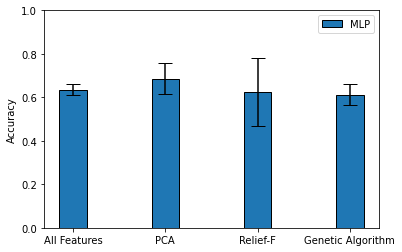

In [25]:
plot_classifier_metric('Accuracy', final_results)

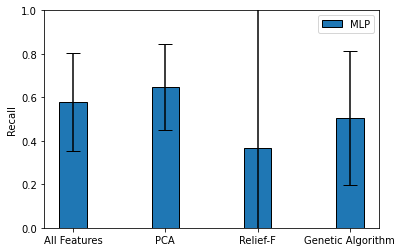

In [26]:
plot_classifier_metric('Recall', final_results)

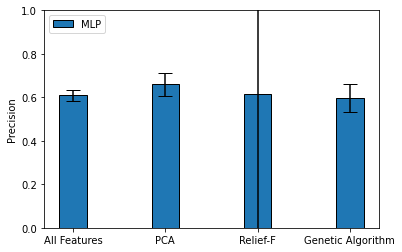

In [27]:
plot_classifier_metric('Precision', final_results)

In [28]:
from io import StringIO

def convert_confidence_interval(value):
    array = value.replace("[", "").replace("]", "").split(" ")
    return [ float(array[0]), float(array[1]) ]

def read_dataset_results_as_string(results_as_string):
  results = pd.read_csv(StringIO(results_as_string))
  del results["Unnamed: 0"]
  results["Accuracy Confidence Interval"] = results["Accuracy Confidence Interval"].apply(convert_confidence_interval)
  results["Recall Confidence Interval"] = results["Recall Confidence Interval"].apply(convert_confidence_interval)
  results["Precision Confidence Interval"] = results["Precision Confidence Interval"].apply(convert_confidence_interval)
  return results

In [29]:
naive_bayes_final_results_as_string = ',Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval\n5,All Features,0.6477290605088583,[0.400387 0.895072],0.7096774193548386,[0.411758 1.007597],0.618683309444179,[0.371354 0.866012]\n10,PCA,0.6467359478380954,[0.556482 0.73699],0.4927419354838709,[0.15926 0.826224],0.6748515499241777,[0.526396 0.823307]\n9,Relief-F,0.7098931065525771,[0.552904 0.866883],0.6395161290322581,[0.44671 0.832322],0.7182658164295527,[0.448781 0.987751]\n5,Genetic Algorithm,0.639985185249928,[0.409374 0.870596],0.6419354838709678,[0.365135 0.918736],0.6303124642670126,[0.336501 0.924123]\n'
naive_bayes_final_results = read_dataset_results_as_string(naive_bayes_final_results_as_string)
naive_bayes_final_results

,Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,All Features,0.647729,"[0.400387, 0.895072]",0.709677,"[0.411758, 1.007597]",0.618683,"[0.371354, 0.866012]"
1,PCA,0.646736,"[0.556482, 0.73699]",0.492742,"[0.15926, 0.826224]",0.674852,"[0.526396, 0.823307]"
2,Relief-F,0.709893,"[0.552904, 0.866883]",0.639516,"[0.44671, 0.832322]",0.718266,"[0.448781, 0.987751]"
3,Genetic Algorithm,0.639985,"[0.409374, 0.870596]",0.641935,"[0.365135, 0.918736]",0.630312,"[0.336501, 0.924123]"


In [30]:
svm_final_results_as_string = ',Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval\n0,All Features,0.0,[0.0 0.0],0.0,[0.0 0.0],0.0,[0.0 0.0]\n1,PCA,0.9431199907353185,[0.862709 1.023531],0.9201612903225806,[0.814685 1.025637],0.9538168707471693,[0.872628 1.035006]\n2,Relief-F,0.8477101596846511,[0.755513 0.939908],0.7572580645161291,[0.575907 0.938609],0.8958335877860595,[0.807363 0.984304]\n3,Genetic Algorithm,0.8499438437939744,[0.781781 0.918106],0.8161290322580644,[0.747391 0.884868],0.8537609846833637,[0.748226 0.959296]\n'
svm_final_results = read_dataset_results_as_string(svm_final_results_as_string)
svm_final_results

,Datasets,Mean Accuracy,Accuracy Confidence Interval,Mean Recall,Recall Confidence Interval,Mean Precision,Precision Confidence Interval
0,All Features,0.000000,"[0.0, 0.0]",0.000000,"[0.0, 0.0]",0.000000,"[0.0, 0.0]"
1,PCA,0.943120,"[0.862709, 1.023531]",0.920161,"[0.814685, 1.025637]",0.953817,"[0.872628, 1.035006]"
2,Relief-F,0.847710,"[0.755513, 0.939908]",0.757258,"[0.575907, 0.938609]",0.895834,"[0.807363, 0.984304]"
3,Genetic Algorithm,0.849944,"[0.781781, 0.918106]",0.816129,"[0.747391, 0.884868]",0.853761,"[0.748226, 0.959296]"


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_metric_classifier(metric_name, dataset_labels, classifier_metrics):
    # width of the bars
    barWidth = 0.3
    i = 0
    
    for means, confidence_intervals, classifier in classifier_metrics:
        yer = list(map(lambda cf: (cf[1] - cf[0]) / 2, confidence_intervals))
        r = np.arange(len(means))

        plt.bar(r + (i * 0.3), means, width = barWidth, edgecolor = 'black', yerr=yer, capsize=7, label=classifier)
        i = i + 1

    # general layout
    total_metrics = len(dataset_labels)

    plt.xticks([r + (0.275) for r in range(total_metrics)], dataset_labels)
    plt.ylim(( 0, 1.25 ))
    plt.ylabel(metric_name)
    plt.legend()

    # Show graphic
    plt.show()
    
def plot_metric_classifier_for_metric(metric_name, results, classifiers):
    dataset_labels = results[0]['Datasets'].values
    classifier_metrics = []
    for i in range(len(results)):
        result = results[i]
        classifier = classifiers[i]
        
        classifier_metrics.append(
            (result[f'Mean {metric_name}'].values, result[f'{metric_name} Confidence Interval'].values, classifier)
        )
    plot_metric_classifier(metric_name, dataset_labels, classifier_metrics)

results = [naive_bayes_final_results, svm_final_results, final_results]
classifiers = ['Naive-Bayes', 'SVM', 'MLP']

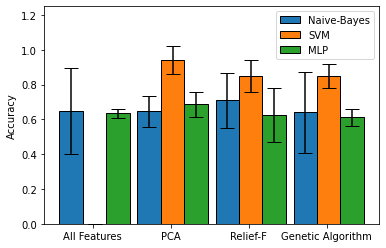

In [32]:
plot_metric_classifier_for_metric('Accuracy', results, classifiers)

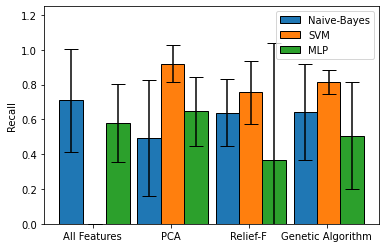

In [33]:
plot_metric_classifier_for_metric('Recall', results, classifiers)

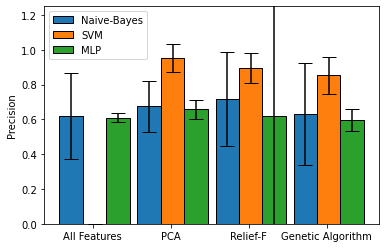

In [34]:
plot_metric_classifier_for_metric('Precision', results, classifiers)